# Introdução

Aplicação de Classificadores para Sistemas de Detecção de Intrusão com Scikit-Learn e KDDCup dataset.

In [1]:
%pip install pandas scikit-learn ray tabulate matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1. Análise Inicial de Dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [3]:
file = "KDDCup_balanceado - KDDCup_balanceado.csv"

df_0 = pd.read_csv(file)
df_0.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90747 entries, 0 to 90746
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   90746 non-null  float64
 1   duration                     90747 non-null  int64  
 2   protocol_type                90744 non-null  object 
 3   service                      90740 non-null  object 
 4   flag                         90742 non-null  object 
 5   src_bytes                    90747 non-null  int64  
 6   dst_bytes                    90747 non-null  int64  
 7   land                         90747 non-null  int64  
 8   wrong_fragment               90747 non-null  int64  
 9   urgent                       90747 non-null  int64  
 10  hot                          90747 non-null  int64  
 11  num_failed_logins            90747 non-null  int64  
 12  logged_in                    90747 non-null  int64  
 13  num_compromised 

In [4]:
# total de valores faltando
print('Linhas com valores faltando: ', df_0.isnull().sum().sum())

# removendo os valores faltando
# antes
print(len(df_0))

df_1 = df_0.dropna()

# depois
print(len(df_1))

Linhas com valores faltando:  23
90747
90725


## 2. Pré-processamento

In [5]:
pd.set_option('display.max_columns', None)
df_1.head()

,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0.0,184,tcp,telnet,SF,1511,2957,0,0,0,3,0,1,2,1,0,0,1,0,0,0.0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.00,0.00,1.00,0.67,0.0,0.0,0.0,0.0,buffer_overflow.
1,1.0,305,tcp,telnet,SF,1735,2766,0,0,0,3,0,1,2,1,0,0,1,0,0,0.0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,4.0,1.00,0.00,0.50,0.50,0.0,0.0,0.0,0.0,buffer_overflow.
2,2.0,79,tcp,telnet,SF,281,1301,0,0,0,2,0,1,1,1,0,0,4,2,0,0.0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,10.0,1.00,0.00,1.00,0.30,0.0,0.0,0.0,0.1,loadmodule.
3,3.0,25,tcp,telnet,SF,269,2333,0,0,0,0,0,1,0,1,0,2,2,1,0,0.0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69.0,2.0,0.03,0.06,0.01,0.00,0.0,0.0,0.0,0.0,perl.
4,4.0,23,tcp,telnet,SF,104,276,0,0,0,0,5,0,0,0,0,0,0,0,0,0.0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.00,0.00,1.00,1.00,0.0,0.0,0.0,0.0,guess_passwd.


In [6]:
# dados categóricos
cols = ['protocol_type',
        'service',
        'flag',
        'outcome']

total = 0

for col in cols:
    u = df_1[col].unique()
    total += len(u)
    print(u)

print(total)

['tcp' 'icmp' 'udp']
['telnet' 'ecr_i' 'private' 'ftp_data' 'netstat' 'daytime' 'ssh' 'echo'
 'ftp' 'smtp' 'time' 'name' 'whois' 'domain' 'mtp' 'gopher' 'remote_job'
 'finger' 'rje' 'ctf' 'http' 'supdup' 'link' 'systat' 'discard' 'login'
 'imap4' 'eco_i' 'domain_u' 'nntp' 'uucp' 'X11' 'pm_dump' 'other' 'Z39_50'
 'netbios_dgm' 'ldap' 'sunrpc' 'courier' 'exec' 'bgp' 'csnet_ns'
 'http_443' 'klogin' 'printer' 'netbios_ssn' 'pop_2' 'nnsp' 'pop_3' 'auth'
 'efs' 'hostnames' 'uucp_path' 'sql_net' 'vmnet' 'iso_tsap' 'netbios_ns'
 'shell' 'kshell' 'http_2784' 'harvest' 'IRC' 'aol' 'http_8001' 'tim_i'
 'urp_i' 'ntp_u']
['SF' 'S3' 'RSTO' 'RSTR' 'REJ' 'RSTOS0' 'S0' 'S2' 'SH' 'S1' 'OTH']
['buffer_overflow.' 'loadmodule.' 'perl.' 'guess_passwd.' 'pod.'
 'teardrop.' 'portsweep.' 'ipsweep.' 'land.' 'ftp_write.' 'back.' 'imap.'
 'satan.' 'phf.' 'nmap.' 'multihop.' 'warezmaster.' 'warezclient.' 'spy.'
 'rootkit.' 'smurf.' 'neptune.' 'normal.']
104


In [7]:
# split X, y
df_y_raw = df_1['outcome'].to_frame()
df_x_raw = df_1.drop(['Unnamed: 0', 'outcome'], axis=1)

print(df_y_raw.info(), end='\n\n\n')
print(df_x_raw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90725 entries, 0 to 90746
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   outcome  90725 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB
None


<class 'pandas.core.frame.DataFrame'>
Index: 90725 entries, 0 to 90746
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     90725 non-null  int64  
 1   protocol_type                90725 non-null  object 
 2   service                      90725 non-null  object 
 3   flag                         90725 non-null  object 
 4   src_bytes                    90725 non-null  int64  
 5   dst_bytes                    90725 non-null  int64  
 6   land                         90725 non-null  int64  
 7   wrong_fragment               90725 non-null  int64  
 8   urgent                       90725 non-null  int64

In [8]:
# normalizar dados

df_x = pd.get_dummies(df_x_raw)
codes, _ = pd.factorize(df_y_raw['outcome'])
df_y = pd.DataFrame(codes, columns=['outcome'])

print(df_x.columns)
print(df_y.columns)

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=119)
Index(['outcome'], dtype='object')


## 3. Separação de dados de treino e teste

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(72580, 119)
(18145, 119)
(72580, 1)
(18145, 1)


## 4. Treinamento e ajuste de hiperparâmetros

In [10]:
# treinamento

# para cada modelo:
#     para cada hiperparâmetro:
#         aplicar cross_validation

templates = [
    {
        'name': 'KNeighborsClassifier',
        'model': lambda x: KNeighborsClassifier(n_neighbors=x),
        'value': tune.grid_search([4, 5, 6, 8, 10]),
    },
    {
        'name': 'LinearSVC',
        'model': lambda x: LinearSVC(C=x),
        'value': tune.grid_search([0.8, 0.9, 1.0, 1.1, 1.2]),
    },
    {
        'name': 'DecisionTreeClassifier',
        'model': lambda x: DecisionTreeClassifier(max_depth=x),
        'value': tune.grid_search([2, 4, 6, 8, 16]),
    }
]

results = dict(zip([t['name'] for t in templates], [None, None, None]))


def tuner_objective(config):
    model = config['model'](config['value'])

    scores = cross_val_score(model, df_x, np.ravel(df_y), cv=5)

    return {
        'score': np.average(scores),
        'std': np.std(scores),
    }


for t in templates:
    param_space = t

    print('Running ', t['name'])
    tuner = tune.Tuner(tuner_objective, param_space=param_space)
    results[t['name']] = tuner.fit()


Running  KNeighborsClassifier


2023-06-09 14:16:13,133	INFO worker.py:1636 -- Started a local Ray instance.
2023-06-09 14:16:13,877	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2023-06-09 14:16:13,879	WARNING syncer.py:222 -- You are using remote storage, but you don't have `fsspec` installed. This can lead to inefficient syncing behavior. To avoid this, install fsspec with `pip install fsspec`. Depending on your remote storage provider, consider installing the respective fsspec-package (see https://github.com/fsspec).
2023-06-09 14:16:13,994	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-06-09 14:16:13,995	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


2023-06-09 14:16:14,916	WARNING worker.py:2019 -- Warning: The actor ImplicitFunc is very large (69 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(tuner_objective pid=45855) /home/leoven/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
(tuner_objective pid=45855)   warnings.warn(


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,score,std,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
tuner_objective_6d749_00000,2023-06-09_14-18-23,True,0_value=4,DELLGCQM3T3,1,172.25.118.190,45851,0.940645,0.0343552,126.982,126.982,126.982,1686313103,1,6d749_00000
tuner_objective_6d749_00001,2023-06-09_14-18-26,True,1_value=5,DELLGCQM3T3,1,172.25.118.190,45852,0.938385,0.0339368,129.46,129.46,129.46,1686313106,1,6d749_00001
tuner_objective_6d749_00002,2023-06-09_14-18-24,True,2_value=6,DELLGCQM3T3,1,172.25.118.190,45853,0.938573,0.033255,128.017,128.017,128.017,1686313104,1,6d749_00002
tuner_objective_6d749_00003,2023-06-09_14-18-25,True,3_value=8,DELLGCQM3T3,1,172.25.118.190,45854,0.939223,0.0316201,129.008,129.008,129.008,1686313105,1,6d749_00003
tuner_objective_6d749_00004,2023-06-09_14-18-23,True,4_value=10,DELLGCQM3T3,1,172.25.118.190,45855,0.937768,0.0343567,126.452,126.452,126.452,1686313103,1,6d749_00004


2023-06-09 14:18:26,098	INFO tune.py:1111 -- Total run time: 132.22 seconds (132.09 seconds for the tuning loop).
2023-06-09 14:18:26,487	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Running  LinearSVC


2023-06-09 14:18:27,255	WARNING worker.py:2019 -- Warning: The actor ImplicitFunc is very large (69 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(tuner_objective pid=46643) /home/leoven/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5. [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(tuner_objective pid=46643)   warnings.warn( [repeated 5x across cluster]
(tuner_objective pid=46646) /home/leoven/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tuner_objective pid=46642) /home/leo

Trial name,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,score,std,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
tuner_objective_bc6af_00000,2023-06-09_14-30-48,True,0_value=0.8000,DELLGCQM3T3,1,172.25.118.190,46642,0.913376,0.0298181,739.841,739.841,739.841,1686313848,1,bc6af_00000
tuner_objective_bc6af_00001,2023-06-09_14-31-04,True,1_value=0.9000,DELLGCQM3T3,1,172.25.118.190,46643,0.926503,0.0213092,755.686,755.686,755.686,1686313864,1,bc6af_00001
tuner_objective_bc6af_00002,2023-06-09_14-30-58,True,2_value=1.0000,DELLGCQM3T3,1,172.25.118.190,46644,0.929711,0.0216767,749.11,749.11,749.11,1686313858,1,bc6af_00002
tuner_objective_bc6af_00003,2023-06-09_14-31-07,True,3_value=1.1000,DELLGCQM3T3,1,172.25.118.190,46645,0.936104,0.0162471,758.095,758.095,758.095,1686313867,1,bc6af_00003
tuner_objective_bc6af_00004,2023-06-09_14-31-08,True,4_value=1.2000,DELLGCQM3T3,1,172.25.118.190,46646,0.915613,0.0517893,759.873,759.873,759.873,1686313868,1,bc6af_00004


(tuner_objective pid=46642)   warnings.warn(
(tuner_objective pid=46642)   warnings.warn(
(tuner_objective pid=46644) /home/leoven/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tuner_objective pid=46644)   warnings.warn(
(tuner_objective pid=46643)   warnings.warn(
(tuner_objective pid=46643)   warnings.warn(
(tuner_objective pid=46645) /home/leoven/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(tuner_objective pid=46645)   warnings.warn(
2023-06-09 14:31:08,903	INFO tune.py:1111 -- Total run time: 762.49 seconds (762.39 seconds for the tuning loop).
2023-06-09 14:31:09,024	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX insta

Running  DecisionTreeClassifier


2023-06-09 14:31:09,799	WARNING worker.py:2019 -- Warning: The actor ImplicitFunc is very large (69 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(tuner_objective pid=50329) /home/leoven/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,score,std,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
tuner_objective_82ef6_00000,2023-06-09_14-31-12,True,0_value=2,DELLGCQM3T3,1,172.25.118.190,50327,0.503136,0.00191154,0.671813,0.671813,0.671813,1686313872,1,82ef6_00000
tuner_objective_82ef6_00001,2023-06-09_14-31-12,True,1_value=4,DELLGCQM3T3,1,172.25.118.190,50329,0.813591,0.0407311,0.981323,0.981323,0.981323,1686313872,1,82ef6_00001
tuner_objective_82ef6_00002,2023-06-09_14-31-12,True,2_value=6,DELLGCQM3T3,1,172.25.118.190,50328,0.921356,0.0275947,1.09906,1.09906,1.09906,1686313872,1,82ef6_00002
tuner_objective_82ef6_00003,2023-06-09_14-31-13,True,3_value=8,DELLGCQM3T3,1,172.25.118.190,50330,0.937735,0.023044,1.22183,1.22183,1.22183,1686313873,1,82ef6_00003
tuner_objective_82ef6_00004,2023-06-09_14-31-13,True,4_value=16,DELLGCQM3T3,1,172.25.118.190,50331,0.953001,0.0282976,1.38074,1.38074,1.38074,1686313873,1,82ef6_00004


2023-06-09 14:31:13,191	INFO tune.py:1111 -- Total run time: 4.24 seconds (4.15 seconds for the tuning loop).


In [11]:
# Resultados

for k, v in results.items():
    print('Result for ', k)
    print(v.get_best_result(metric='score', mode='max'))
    print('\n\n')

Result for  KNeighborsClassifier
Result(
  metrics={'score': 0.9406448057316066, 'std': 0.034355159319420785, 'done': True, 'trial_id': '6d749_00000', 'experiment_tag': '0_value=4'},
  path='/home/leoven/ray_results/tuner_objective_2023-06-09_14-16-11/tuner_objective_6d749_00000_0_value=4_2023-06-09_14-16-14',
  checkpoint=None
)



Result for  LinearSVC
Result(
  metrics={'score': 0.936103609809865, 'std': 0.016247124305770584, 'done': True, 'trial_id': 'bc6af_00003', 'experiment_tag': '3_value=1.1000'},
  path='/home/leoven/ray_results/tuner_objective_2023-06-09_14-18-26/tuner_objective_bc6af_00003_3_value=1.1000_2023-06-09_14-18-27',
  checkpoint=None
)



Result for  DecisionTreeClassifier
Result(
  metrics={'score': 0.9530008266740149, 'std': 0.028297612756196827, 'done': True, 'trial_id': '82ef6_00004', 'experiment_tag': '4_value=16'},
  path='/home/leoven/ray_results/tuner_objective_2023-06-09_14-31-08/tuner_objective_82ef6_00004_4_value=16_2023-06-09_14-31-09',
  checkpoint=Non

In [12]:
# modelos finais

n_neighbors = 4
C = 0.8
max_depth = 16

model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
model_svc = LinearSVC(C=C)
model_dtc = DecisionTreeClassifier(max_depth=max_depth)

model_knn = model_knn.fit(x_train, np.ravel(y_train))
model_svc = model_svc.fit(x_train, np.ravel(y_train))
model_dtc = model_dtc.fit(x_train, np.ravel(y_train))

/home/leoven/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 5. Visualização dos resultados

In [13]:
y_knn_pred = model_knn.predict(x_test)
y_svc_pred = model_svc.predict(x_test)
y_dtc_pred = model_dtc.predict(x_test)

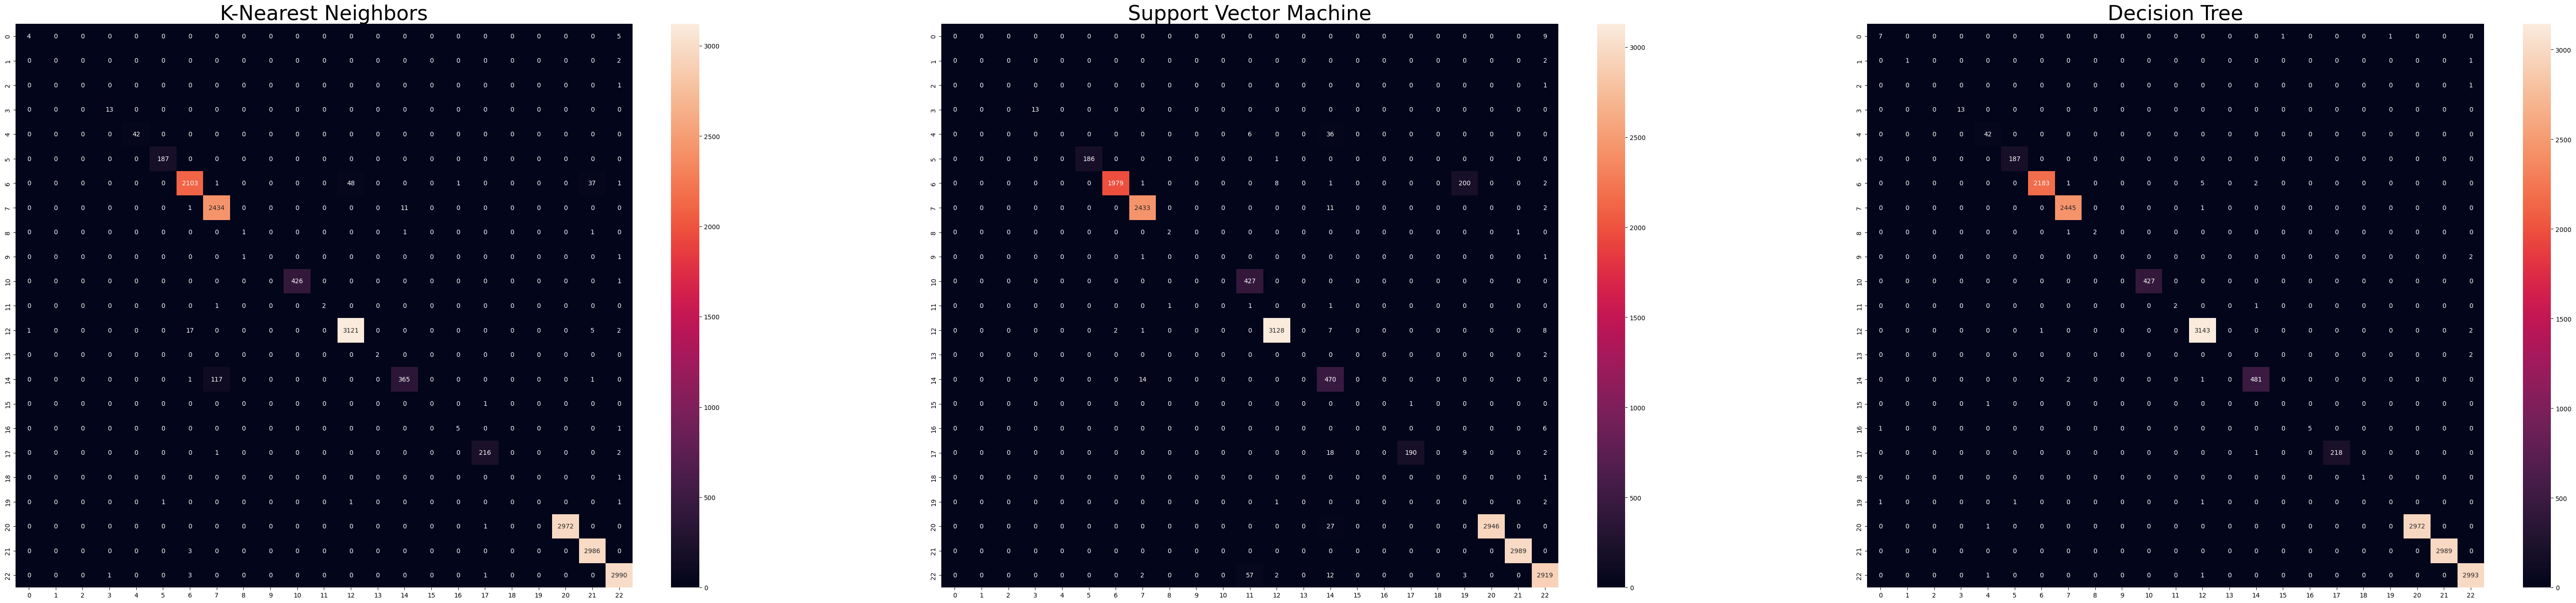

In [14]:
cm_knn = confusion_matrix(y_test, y_knn_pred)
cm_svc = confusion_matrix(y_test, y_svc_pred)
cm_dtc = confusion_matrix(y_test, y_dtc_pred)

plt.figure(figsize=(74, 16))
plt.subplot(1, 3, 1)
plt.title('K-Nearest Neighbors', fontdict={'fontsize': 32})
sns.heatmap(cm_knn, annot=True, fmt='d')
plt.subplot(1, 3, 2)
plt.title('Support Vector Machine', fontdict={'fontsize': 32})
sns.heatmap(cm_svc, annot=True, fmt='d')
plt.subplot(1, 3, 3)
plt.title('Decision Tree', fontdict={'fontsize': 32})
sns.heatmap(cm_dtc, annot=True, fmt='d')
plt.show()

## 6. Comparação de desempenho de diferentes classificadores

/home/leoven/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leoven/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leoven/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


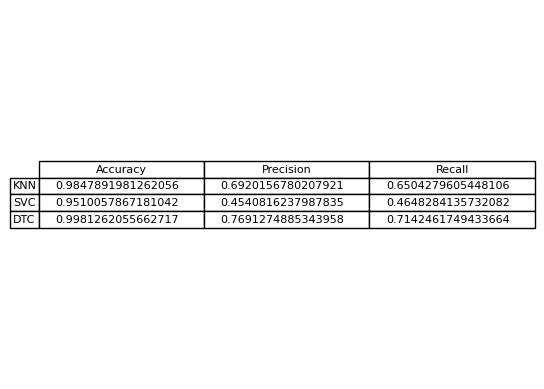

In [15]:
table = [
    [
        accuracy_score(y_test, y_knn_pred),
        precision_score(y_test, y_knn_pred, average='macro'),
        recall_score(y_test, y_knn_pred, average='macro'),
    ],
    [
        accuracy_score(y_test, y_svc_pred),
        precision_score(y_test, y_svc_pred, average='macro'),
        recall_score(y_test, y_svc_pred, average='macro'),
    ],
    [
        accuracy_score(y_test, y_dtc_pred),
        precision_score(y_test, y_dtc_pred, average='macro'),
        recall_score(y_test, y_dtc_pred, average='macro'),
    ]
]

fig, ax = plt.subplots()
ax.set_axis_off()

plt.table(table, colLabels=["Accuracy", "Precision", "Recall"], rowLabels=["KNN", "SVC", "DTC"], loc='center', cellLoc='left')
plt.show()
